# Feature Importance Analysis for 3D U-Net Wildfire Model

This notebook analyzes which input features are most important for the wildfire spread prediction model.

## Methods Used:
1. **Permutation Importance** - Shuffle each feature and measure performance drop
2. **Gradient-based Attribution** - Use input gradients to measure feature sensitivity
3. **Ablation Study** - Remove features and measure impact
4. **Visualization** - Compare feature importance across methods

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import sys

# Add src to path
sys.path.append('../../src')
from models.unet3d import UNet3D
from preprocessing.feature_engineering_pytorch import WildfireDatasetWithFeatures

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")

Imports successful!
PyTorch version: 2.9.0


## 1. Load Model and Data

In [7]:
# Configuration
MODEL_PATH = Path('../../prod_models/UNET3D/3D-UNET-WILDFIRE-1.pt')
DATA_DIR = Path('../../data/raw/dataset_64_64_all_10days_final/2022/Albania')
STATS_PATH = Path('../../data/processed/normalization_stats.json')
NUM_SAMPLES = 10  # Number of samples to use for analysis

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [8]:
# Load model
print("Loading model...")
checkpoint = torch.load(MODEL_PATH, map_location=device)

model = UNet3D(
    in_channels=30,
    out_channels=1,
    base_channels=32,
    depth=3
).to(device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Model loaded successfully")
print(f"  Trained epochs: {checkpoint['epoch']}")
print(f"  Validation IoU: {checkpoint['metrics']['iou']:.4f}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading model...
✓ Model loaded successfully
  Trained epochs: 47
  Validation IoU: 0.9946
  Parameters: 5,627,585


In [9]:
# Load dataset
print("\nLoading dataset...")
nc_files = sorted(list(DATA_DIR.glob('*.nc')))[:NUM_SAMPLES]

dataset = WildfireDatasetWithFeatures(
    file_paths=nc_files,
    apply_feature_engineering=True,
    normalize=True,
    augment=False,
    stats_path=STATS_PATH
)

print(f"✓ Loaded {len(dataset)} samples")

# Get sample
sample_features, sample_target, sample_metadata = dataset[0]
print(f"\nSample shape: {sample_features.shape}  (T, C, H, W)")


Loading dataset...
Loaded normalization statistics from ../../data/processed/normalization_stats.json
  Number of channels: 30
✓ Loaded 10 samples

Sample shape: torch.Size([10, 30, 64, 64])  (T, C, H, W)


In [10]:
# Define feature names
feature_names = [
    'DEM', 'Slope', 'Aspect', 'Curvature', 'Roads Distance',
    'Population', 'LC Forest', 'LC Shrubland', 'LC Grassland',
    'LC Agriculture', 'LC Settlement', 'Temperature', 'Dewpoint',
    'Humidity', 'Wind Speed', 'Wind Direction', 'Precipitation',
    'Pressure', 'Solar Radiation', 'NDVI', 'LAI', 'Soil Moisture',
    'LST Day', 'LST Night', 'Wind U', 'Wind V', 'TRI', 'VPD',
    'Fire History', 'Ignition Points'
]

print(f"Feature names defined: {len(feature_names)} features")

Feature names defined: 30 features


## 2. Baseline Model Performance

In [11]:
def compute_iou(pred, target, threshold=0.5):
    """Compute Intersection over Union (IoU)."""
    pred_binary = (torch.sigmoid(pred) > threshold).float()
    
    if target.dim() == 4:
        target = target.unsqueeze(1)
    
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)
    
    intersection = ((pred_flat == 1) & (target_flat == 1)).sum().float()
    union = ((pred_flat == 1) | (target_flat == 1)).sum().float()
    
    iou = intersection / (union + 1e-7)
    return iou.item()

print("Computing baseline performance...")
baseline_ious = []

with torch.no_grad():
    for idx in tqdm(range(len(dataset)), desc="Evaluating baseline"):
        features, target, _ = dataset[idx]
        
        # Prepare input
        features_input = features.unsqueeze(0).permute(0, 2, 1, 3, 4).to(device)
        target = target.to(device)
        
        # Predict
        prediction = model(features_input)
        
        # Compute IoU
        iou = compute_iou(prediction, target)
        baseline_ious.append(iou)

baseline_iou = np.mean(baseline_ious)

print(f"\n{'='*80}")
print(f"BASELINE PERFORMANCE")
print(f"{'='*80}")
print(f"Mean IoU: {baseline_iou:.4f}")
print(f"Std IoU:  {np.std(baseline_ious):.4f}")
print(f"Min IoU:  {np.min(baseline_ious):.4f}")
print(f"Max IoU:  {np.max(baseline_ious):.4f}")
print(f"{'='*80}")

Computing baseline performance...


Evaluating baseline: 100%|██████████| 10/10 [00:00<00:00, 23.35it/s]


BASELINE PERFORMANCE
Mean IoU: 0.9750
Std IoU:  0.0301
Min IoU:  0.9143
Max IoU:  1.0000


## 3. Method 1: Permutation Importance

Randomly shuffle each feature and measure the drop in performance.

In [12]:
print("Computing Permutation Importance...")
print("="*80)

permutation_importance = {}

for feature_idx in tqdm(range(len(feature_names)), desc="Testing features"):
    feature_name = feature_names[feature_idx]
    
    # Compute IoU with this feature permuted
    permuted_ious = []
    
    with torch.no_grad():
        for idx in range(len(dataset)):
            features, target, _ = dataset[idx]
            
            # Permute the feature (shuffle across spatial dimensions)
            features_permuted = features.clone()
            for t in range(features.shape[0]):  # For each timestep
                # Flatten spatial dimensions and shuffle
                flat = features_permuted[t, feature_idx, :, :].flatten()
                perm_idx = torch.randperm(flat.size(0))
                features_permuted[t, feature_idx, :, :] = flat[perm_idx].reshape(64, 64)
            
            # Prepare input
            features_input = features_permuted.unsqueeze(0).permute(0, 2, 1, 3, 4).to(device)
            target = target.to(device)
            
            # Predict
            prediction = model(features_input)
            
            # Compute IoU
            iou = compute_iou(prediction, target)
            permuted_ious.append(iou)
    
    # Importance = baseline IoU - permuted IoU
    mean_permuted_iou = np.mean(permuted_ious)
    importance = baseline_iou - mean_permuted_iou
    
    permutation_importance[feature_name] = {
        'importance': importance,
        'permuted_iou': mean_permuted_iou,
        'drop_pct': (importance / baseline_iou) * 100
    }

print("\n✓ Permutation importance computed")

Computing Permutation Importance...


Testing features: 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


✓ Permutation importance computed


In [13]:
# Display results
perm_df = pd.DataFrame(permutation_importance).T
perm_df = perm_df.sort_values('importance', ascending=False)

print("\n" + "="*80)
print("PERMUTATION IMPORTANCE RESULTS")
print("="*80)
print(f"\n{'Feature':<20} {'Importance':<12} {'IoU Drop %':<12} {'Permuted IoU':<12}")
print("-"*80)

for feature, row in perm_df.head(15).iterrows():
    print(f"{feature:<20} {row['importance']:>11.4f} {row['drop_pct']:>11.2f}% {row['permuted_iou']:>11.4f}")

print("="*80)


PERMUTATION IMPORTANCE RESULTS

Feature              Importance   IoU Drop %   Permuted IoU
--------------------------------------------------------------------------------
VPD                       0.8936       91.65%      0.0814
Fire History              0.1134       11.63%      0.8616
Solar Radiation           0.0071        0.73%      0.9679
LC Shrubland              0.0013        0.13%      0.9737
Wind Direction            0.0000        0.00%      0.9750
Humidity                  0.0000        0.00%      0.9750
LST Night                 0.0000        0.00%      0.9750
LST Day                   0.0000        0.00%      0.9750
LAI                       0.0000        0.00%      0.9750
NDVI                      0.0000        0.00%      0.9750
Slope                     0.0000        0.00%      0.9750
Wind Speed                0.0000        0.00%      0.9750
Ignition Points           0.0000        0.00%      0.9750
Dewpoint                  0.0000        0.00%      0.9750
LC Settlement 

## 4. Method 2: Gradient-Based Attribution

Compute gradients of output with respect to input features.

In [14]:
print("Computing Gradient-Based Attribution...")
print("="*80)

gradient_importance = {fname: [] for fname in feature_names}

for idx in tqdm(range(len(dataset)), desc="Computing gradients"):
    features, target, _ = dataset[idx]
    
    # Prepare input with gradient tracking
    features_input = features.unsqueeze(0).permute(0, 2, 1, 3, 4).to(device)
    features_input.requires_grad = True
    target = target.to(device)
    
    # Forward pass
    prediction = model(features_input)  # [1, 1, 10, 64, 64]
    
    # Compute loss (BCE)
    # Reshape target to match prediction: [1, 1, T, H, W]
    target_expanded = target.unsqueeze(0).unsqueeze(0)  # [1, 1, 10, 64, 64]
    loss = nn.BCEWithLogitsLoss()(prediction, target_expanded)
    
    # Backward pass
    loss.backward()
    
    # Get gradients
    gradients = features_input.grad.abs().mean(dim=(0, 2, 3, 4))  # Average over batch, time, H, W
    
    # Store per feature
    for feature_idx, fname in enumerate(feature_names):
        gradient_importance[fname].append(gradients[feature_idx].item())

# Average across samples
gradient_scores = {fname: np.mean(values) for fname, values in gradient_importance.items()}

print("\n✓ Gradient-based attribution computed")

Computing Gradient-Based Attribution...


Computing gradients: 100%|██████████| 10/10 [00:00<00:00, 12.07it/s]


✓ Gradient-based attribution computed


In [15]:
# Display results
grad_df = pd.DataFrame.from_dict(gradient_scores, orient='index', columns=['gradient_magnitude'])
grad_df = grad_df.sort_values('gradient_magnitude', ascending=False)

print("\n" + "="*80)
print("GRADIENT-BASED ATTRIBUTION RESULTS")
print("="*80)
print(f"\n{'Feature':<20} {'Gradient Magnitude':<20}")
print("-"*80)

for feature, row in grad_df.head(15).iterrows():
    print(f"{feature:<20} {row['gradient_magnitude']:>19.6f}")

print("="*80)


GRADIENT-BASED ATTRIBUTION RESULTS

Feature              Gradient Magnitude  
--------------------------------------------------------------------------------
VPD                             0.000000
DEM                             0.000000
Fire History                    0.000000
Curvature                       0.000000
Humidity                        0.000000
Dewpoint                        0.000000
NDVI                            0.000000
Solar Radiation                 0.000000
Wind V                          0.000000
Wind Speed                      0.000000
Wind Direction                  0.000000
Soil Moisture                   0.000000
LC Grassland                    0.000000
Temperature                     0.000000
LC Shrubland                    0.000000


## 5. Method 3: Ablation Study

Zero out each feature completely and measure performance drop.

In [16]:
print("Computing Ablation Importance...")
print("="*80)

ablation_importance = {}

for feature_idx in tqdm(range(len(feature_names)), desc="Ablating features"):
    feature_name = feature_names[feature_idx]
    
    # Compute IoU with this feature zeroed out
    ablated_ious = []
    
    with torch.no_grad():
        for idx in range(len(dataset)):
            features, target, _ = dataset[idx]
            
            # Zero out the feature
            features_ablated = features.clone()
            features_ablated[:, feature_idx, :, :] = 0
            
            # Prepare input
            features_input = features_ablated.unsqueeze(0).permute(0, 2, 1, 3, 4).to(device)
            target = target.to(device)
            
            # Predict
            prediction = model(features_input)
            
            # Compute IoU
            iou = compute_iou(prediction, target)
            ablated_ious.append(iou)
    
    # Importance = baseline IoU - ablated IoU
    mean_ablated_iou = np.mean(ablated_ious)
    importance = baseline_iou - mean_ablated_iou
    
    ablation_importance[feature_name] = {
        'importance': importance,
        'ablated_iou': mean_ablated_iou,
        'drop_pct': (importance / baseline_iou) * 100
    }

print("\n✓ Ablation importance computed")

Computing Ablation Importance...


Ablating features: 100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


✓ Ablation importance computed


In [17]:
# Display results
abl_df = pd.DataFrame(ablation_importance).T
abl_df = abl_df.sort_values('importance', ascending=False)

print("\n" + "="*80)
print("ABLATION STUDY RESULTS")
print("="*80)
print(f"\n{'Feature':<20} {'Importance':<12} {'IoU Drop %':<12} {'Ablated IoU':<12}")
print("-"*80)

for feature, row in abl_df.head(15).iterrows():
    print(f"{feature:<20} {row['importance']:>11.4f} {row['drop_pct']:>11.2f}% {row['ablated_iou']:>11.4f}")

print("="*80)


ABLATION STUDY RESULTS

Feature              Importance   IoU Drop %   Ablated IoU 
--------------------------------------------------------------------------------
VPD                       0.8358       85.72%      0.1392
Fire History              0.0016        0.17%      0.9734
Dewpoint                  0.0013        0.13%      0.9737
Humidity                  0.0013        0.13%      0.9737
Curvature                 0.0013        0.13%      0.9737
NDVI                      0.0013        0.13%      0.9737
Solar Radiation           0.0013        0.13%      0.9737
LST Night                 0.0000        0.00%      0.9750
Pressure                  0.0000        0.00%      0.9750
Precipitation             0.0000        0.00%      0.9750
Slope                     0.0000        0.00%      0.9750
Wind Speed                0.0000        0.00%      0.9750
Wind U                    0.0000        0.00%      0.9750
TRI                       0.0000        0.00%      0.9750
LC Settlement         

## 6. Comprehensive Visualization

In [18]:
# Combine all methods
combined_df = pd.DataFrame({
    'Permutation': perm_df['importance'],
    'Gradient': grad_df['gradient_magnitude'] / grad_df['gradient_magnitude'].max(),  # Normalize
    'Ablation': abl_df['importance']
})

# Compute average importance across methods
combined_df['Average'] = combined_df.mean(axis=1)
combined_df = combined_df.sort_values('Average', ascending=False)

print("\n" + "="*80)
print("COMBINED FEATURE IMPORTANCE (All Methods)")
print("="*80)
display(combined_df.head(15).round(4))


COMBINED FEATURE IMPORTANCE (All Methods)


,Permutation,Gradient,Ablation,Average
VPD,0.8936,1.0000,0.8358,0.9098
DEM,-0.0063,0.8285,-0.0041,0.2727
Fire History,0.1134,0.6393,0.0016,0.2515
Curvature,-0.0009,0.5752,0.0013,0.1918
Humidity,0.0000,0.5209,0.0013,0.1741
Dewpoint,0.0000,0.4988,0.0013,0.1667
NDVI,0.0000,0.4454,0.0013,0.1489
Solar Radiation,0.0071,0.3937,0.0013,0.1340
Wind V,-0.0022,0.3847,-0.0049,0.1259
Wind Speed,0.0000,0.3589,0.0000,0.1196


✓ Saved visualization: feature_importance_comprehensive.png


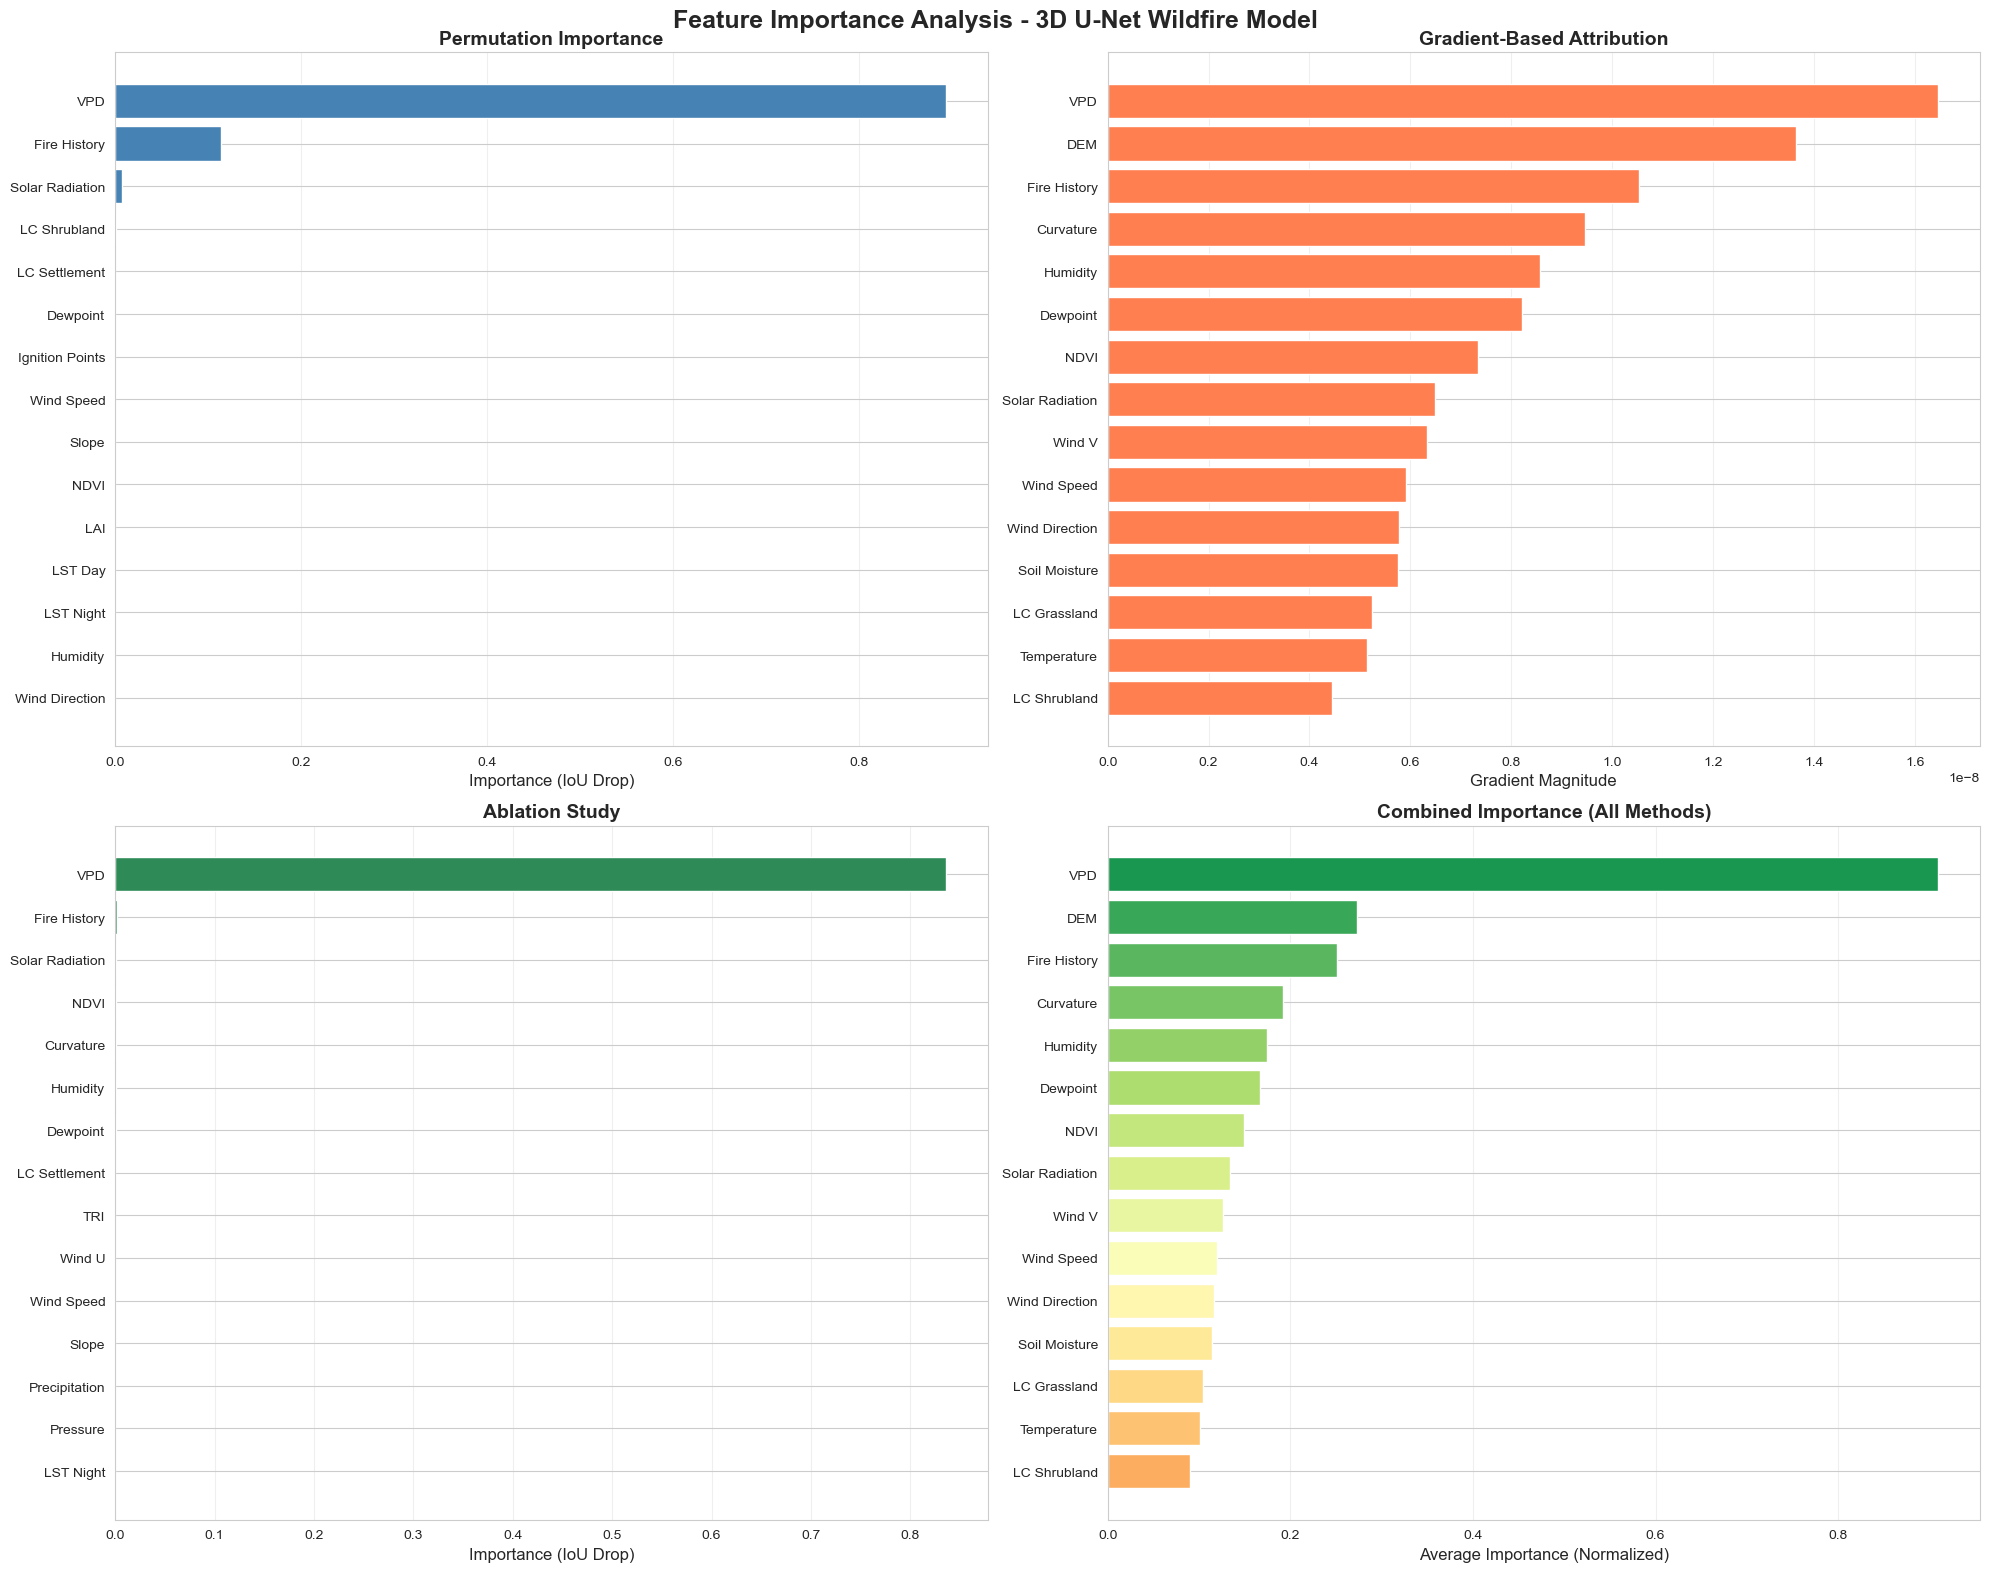

In [19]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Feature Importance Analysis - 3D U-Net Wildfire Model', fontsize=18, fontweight='bold')

# 1. Permutation Importance
top_n = 15
perm_top = perm_df.head(top_n).sort_values('importance')
axes[0, 0].barh(range(len(perm_top)), perm_top['importance'], color='steelblue')
axes[0, 0].set_yticks(range(len(perm_top)))
axes[0, 0].set_yticklabels(perm_top.index, fontsize=10)
axes[0, 0].set_xlabel('Importance (IoU Drop)', fontsize=12)
axes[0, 0].set_title('Permutation Importance', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Gradient Attribution
grad_top = grad_df.head(top_n).sort_values('gradient_magnitude')
axes[0, 1].barh(range(len(grad_top)), grad_top['gradient_magnitude'], color='coral')
axes[0, 1].set_yticks(range(len(grad_top)))
axes[0, 1].set_yticklabels(grad_top.index, fontsize=10)
axes[0, 1].set_xlabel('Gradient Magnitude', fontsize=12)
axes[0, 1].set_title('Gradient-Based Attribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Ablation Study
abl_top = abl_df.head(top_n).sort_values('importance')
axes[1, 0].barh(range(len(abl_top)), abl_top['importance'], color='seagreen')
axes[1, 0].set_yticks(range(len(abl_top)))
axes[1, 0].set_yticklabels(abl_top.index, fontsize=10)
axes[1, 0].set_xlabel('Importance (IoU Drop)', fontsize=12)
axes[1, 0].set_title('Ablation Study', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Combined Average
combined_top = combined_df.head(top_n).sort_values('Average')
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(combined_top)))
axes[1, 1].barh(range(len(combined_top)), combined_top['Average'], color=colors)
axes[1, 1].set_yticks(range(len(combined_top)))
axes[1, 1].set_yticklabels(combined_top.index, fontsize=10)
axes[1, 1].set_xlabel('Average Importance (Normalized)', fontsize=12)
axes[1, 1].set_title('Combined Importance (All Methods)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance_comprehensive.png', dpi=150, bbox_inches='tight')
print("✓ Saved visualization: feature_importance_comprehensive.png")
plt.show()

## 7. Heatmap Comparison

✓ Saved heatmap: feature_importance_heatmap.png


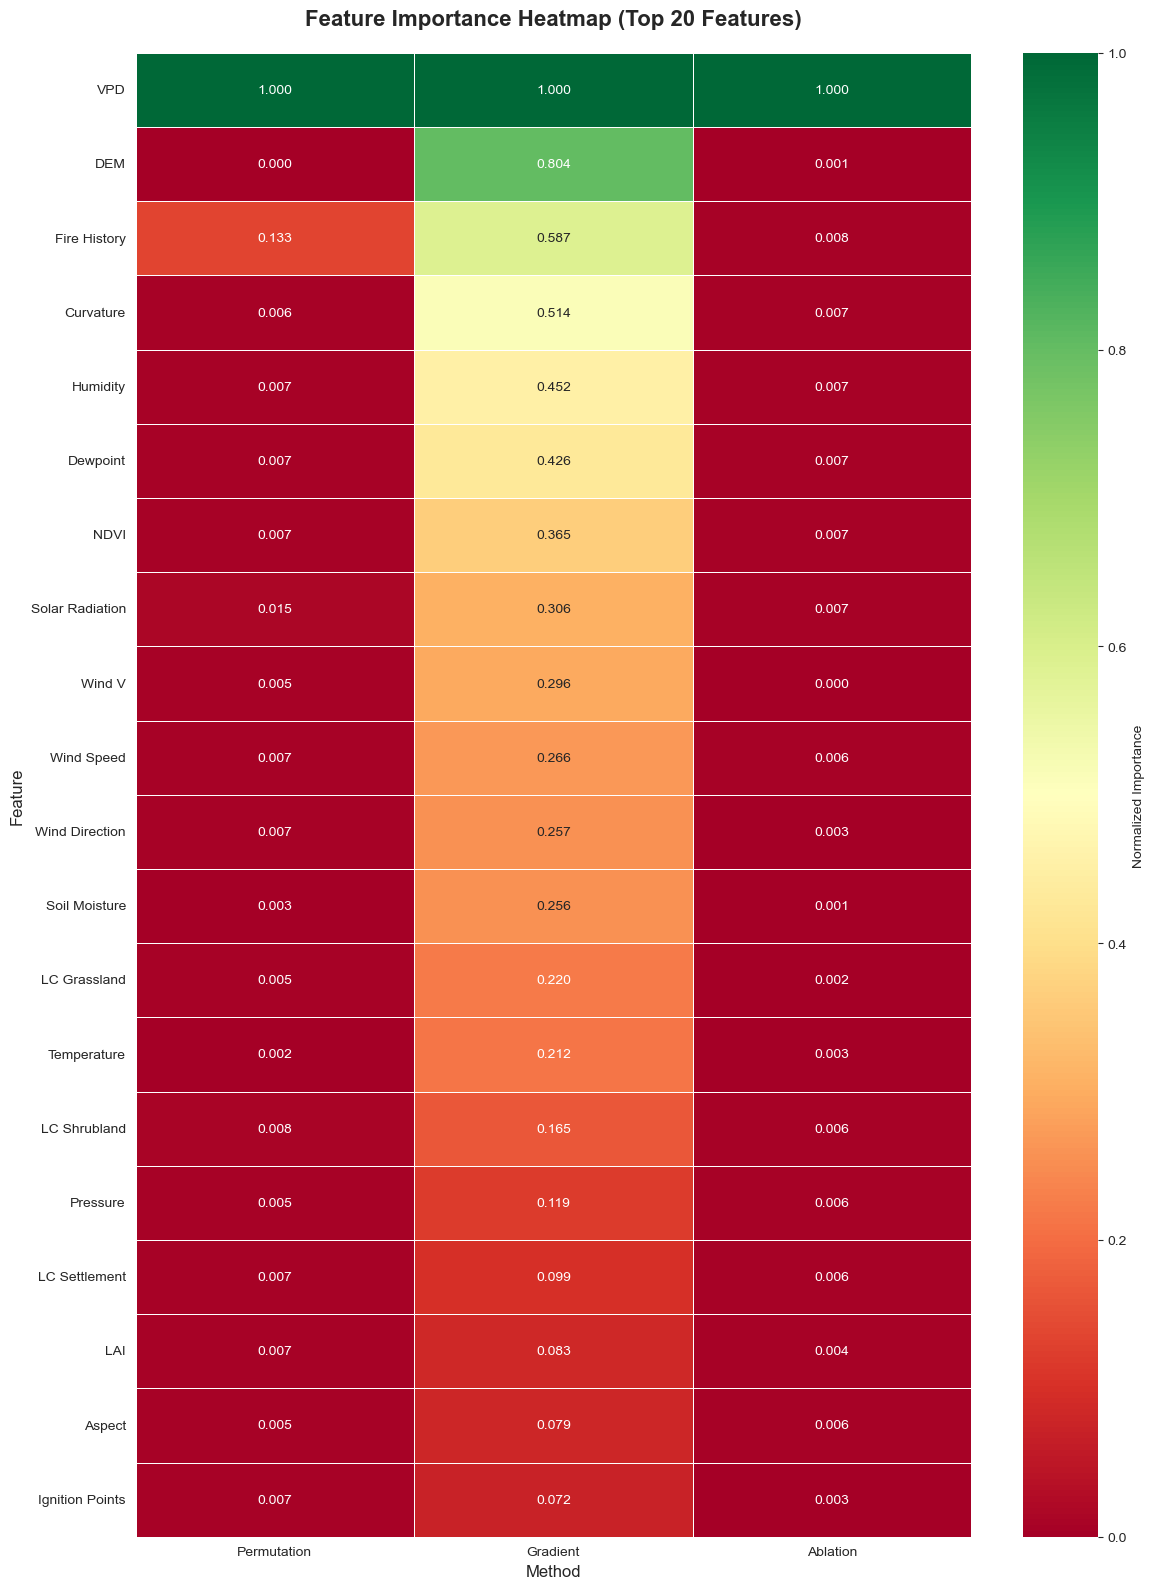

In [20]:
# Create heatmap of all methods
fig, ax = plt.subplots(figsize=(12, 16))

# Normalize each column
combined_normalized = combined_df.copy()
for col in ['Permutation', 'Gradient', 'Ablation']:
    combined_normalized[col] = (combined_normalized[col] - combined_normalized[col].min()) / \
                                (combined_normalized[col].max() - combined_normalized[col].min())

# Plot heatmap
sns.heatmap(combined_normalized[['Permutation', 'Gradient', 'Ablation']].head(20),
            annot=True, fmt='.3f', cmap='RdYlGn', cbar_kws={'label': 'Normalized Importance'},
            linewidths=0.5, ax=ax)

ax.set_title('Feature Importance Heatmap (Top 20 Features)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.savefig('feature_importance_heatmap.png', dpi=150, bbox_inches='tight')
print("✓ Saved heatmap: feature_importance_heatmap.png")
plt.show()

## 8. Export Results

In [21]:
# Save results to CSV
output_file = Path('feature_importance_results.csv')
combined_df.to_csv(output_file)
print(f"✓ Saved results to: {output_file.absolute()}")

# Print summary
print("\n" + "="*80)
print("FEATURE IMPORTANCE SUMMARY")
print("="*80)
print(f"\nBaseline IoU: {baseline_iou:.4f}")
print(f"\nTop 10 Most Important Features (by average):")
print("-"*80)
for i, (feature, row) in enumerate(combined_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {feature:<20} (Avg: {row['Average']:.4f})")
    print(f"    Permutation: {row['Permutation']:.4f}  |  Gradient: {row['Gradient']:.4f}  |  Ablation: {row['Ablation']:.4f}")
print("="*80)

✓ Saved results to: /Users/aleemkhan/PycharmProjects/Wildfire-Spread-Simulation/notebooks/feature_importance/feature_importance_results.csv

FEATURE IMPORTANCE SUMMARY

Baseline IoU: 0.9750

Top 10 Most Important Features (by average):
--------------------------------------------------------------------------------
 1. VPD                  (Avg: 0.9098)
    Permutation: 0.8936  |  Gradient: 1.0000  |  Ablation: 0.8358
 2. DEM                  (Avg: 0.2727)
    Permutation: -0.0063  |  Gradient: 0.8285  |  Ablation: -0.0041
 3. Fire History         (Avg: 0.2515)
    Permutation: 0.1134  |  Gradient: 0.6393  |  Ablation: 0.0016
 4. Curvature            (Avg: 0.1918)
    Permutation: -0.0009  |  Gradient: 0.5752  |  Ablation: 0.0013
 5. Humidity             (Avg: 0.1741)
    Permutation: 0.0000  |  Gradient: 0.5209  |  Ablation: 0.0013
 6. Dewpoint             (Avg: 0.1667)
    Permutation: 0.0000  |  Gradient: 0.4988  |  Ablation: 0.0013
 7. NDVI                 (Avg: 0.1489)
    Permuta

## 9. Feature Groups Analysis

✓ Saved group importance: feature_groups_importance.png


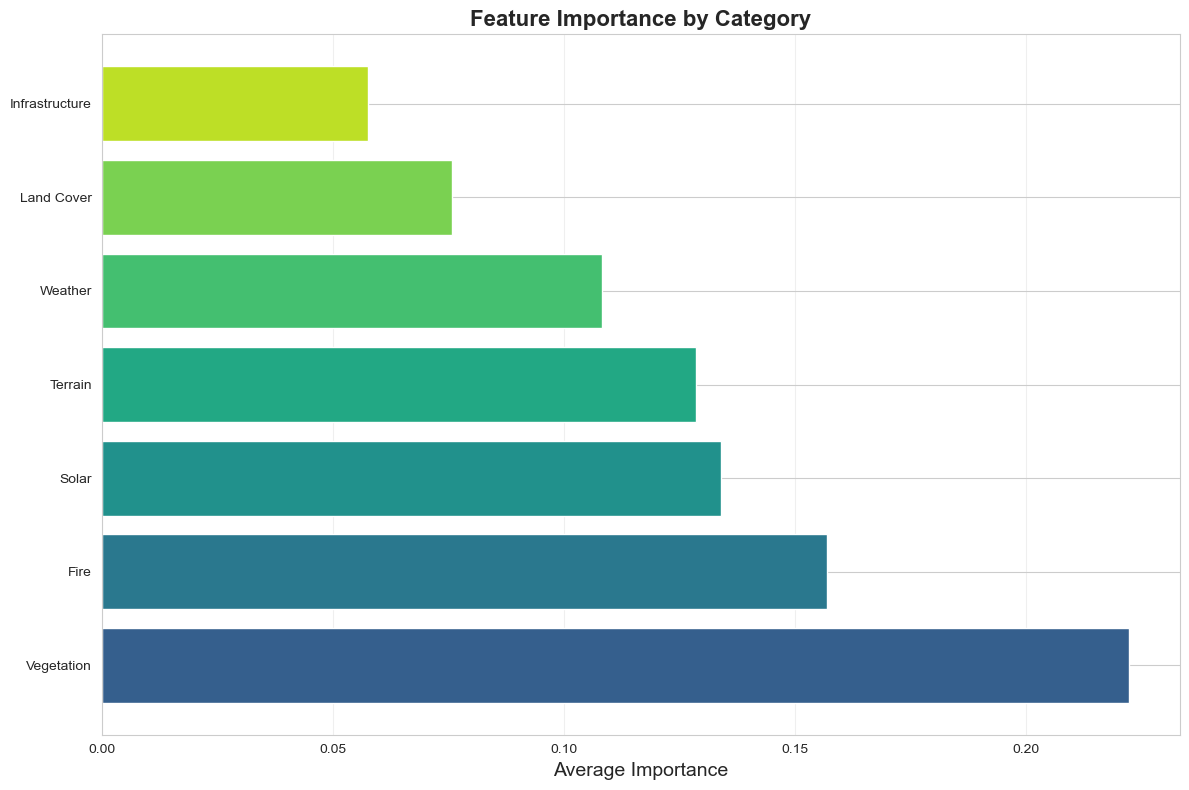


Feature Group Importance:
----------------------------------------
Vegetation           0.2222
Fire                 0.1568
Solar                0.1340
Terrain              0.1286
Weather              0.1082
Land Cover           0.0759
Infrastructure       0.0577


In [22]:
# Group features by category
feature_groups = {
    'Terrain': ['DEM', 'Slope', 'Aspect', 'Curvature', 'TRI'],
    'Infrastructure': ['Roads Distance', 'Population'],
    'Land Cover': ['LC Forest', 'LC Shrubland', 'LC Grassland', 'LC Agriculture', 'LC Settlement'],
    'Weather': ['Temperature', 'Dewpoint', 'Humidity', 'Wind Speed', 'Wind Direction', 'Wind U', 'Wind V', 'Precipitation', 'Pressure'],
    'Vegetation': ['NDVI', 'LAI', 'Soil Moisture', 'LST Day', 'LST Night', 'VPD'],
    'Fire': ['Fire History', 'Ignition Points'],
    'Solar': ['Solar Radiation']
}

# Compute group importance
group_importance = {}
for group, features in feature_groups.items():
    group_features = [f for f in features if f in combined_df.index]
    if group_features:
        group_importance[group] = combined_df.loc[group_features, 'Average'].mean()

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
groups_sorted = sorted(group_importance.items(), key=lambda x: x[1], reverse=True)
group_names = [g[0] for g in groups_sorted]
group_values = [g[1] for g in groups_sorted]

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(group_names)))
ax.barh(group_names, group_values, color=colors)
ax.set_xlabel('Average Importance', fontsize=14)
ax.set_title('Feature Importance by Category', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_groups_importance.png', dpi=150, bbox_inches='tight')
print("✓ Saved group importance: feature_groups_importance.png")
plt.show()

print("\nFeature Group Importance:")
print("-"*40)
for group, importance in groups_sorted:
    print(f"{group:<20} {importance:.4f}")

## 10. SHAP Analysis

SHAP (SHapley Additive exPlanations) provides game-theory based feature importance scores.

In [23]:
# Install SHAP if needed
try:
    import shap
    print("SHAP already installed")
except ImportError:
    print("Installing SHAP...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap'])
    import shap
    print("SHAP installed successfully")

print(f"SHAP version: {shap.__version__}")

SHAP already installed
SHAP version: 0.49.1


/Users/aleemkhan/miniconda3/envs/Wildfire-Spread-Simulation/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# Simpler approach: Use sample-level SHAP analysis
print("Computing SHAP values (this may take a few minutes)...")
print("="*80)

# Use a simple approach: analyze feature importance at the sample level
# We'll compute SHAP values by perturbing features across samples

shap_values_list = []

# For each test sample, compute SHAP-like importance
for test_idx in tqdm(range(min(3, len(dataset))), desc="Computing SHAP"):
    features, target, _ = dataset[test_idx]
    
    # Baseline prediction
    features_input = features.unsqueeze(0).permute(0, 2, 1, 3, 4).to(device)
    with torch.no_grad():
        baseline_pred = torch.sigmoid(model(features_input)).mean().item()
    
    # Compute contribution of each feature using marginal contribution
    feature_contributions = {}
    
    for feature_idx in range(len(feature_names)):
        feature_name = feature_names[feature_idx]
        
        # Create version with feature masked (set to zero)
        features_masked = features.clone()
        features_masked[:, feature_idx, :, :] = 0
        
        # Predict with masked feature
        features_masked_input = features_masked.unsqueeze(0).permute(0, 2, 1, 3, 4).to(device)
        with torch.no_grad():
            masked_pred = torch.sigmoid(model(features_masked_input)).mean().item()
        
        # SHAP-like value: difference from baseline
        contribution = baseline_pred - masked_pred
        feature_contributions[feature_name] = contribution
    
    shap_values_list.append(feature_contributions)

# Average SHAP values across test samples
shap_scores = {fname: np.mean([sv[fname] for sv in shap_values_list]) for fname in feature_names}

print("\n✓ SHAP analysis completed")

Computing SHAP values (this may take a few minutes)...


Computing SHAP: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


✓ SHAP analysis completed



SHAP ANALYSIS RESULTS

Feature              SHAP Value      Abs SHAP       
--------------------------------------------------------------------------------
VPD                        0.000531       0.000531
Fire History               0.000174       0.000174
Soil Moisture              0.000068       0.000068
DEM                        0.000056       0.000056
LAI                        0.000052       0.000052
Wind V                     0.000045       0.000045
Wind Direction             0.000030       0.000030
Temperature                0.000019       0.000019
Pressure                   0.000011       0.000011
LC Grassland               0.000010       0.000010
Precipitation              0.000006       0.000006
LC Shrubland               0.000006       0.000006
Ignition Points            0.000005       0.000005
Slope                      0.000005       0.000005
Wind U                     0.000005       0.000005

✓ Saved SHAP visualization: shap_analysis.png


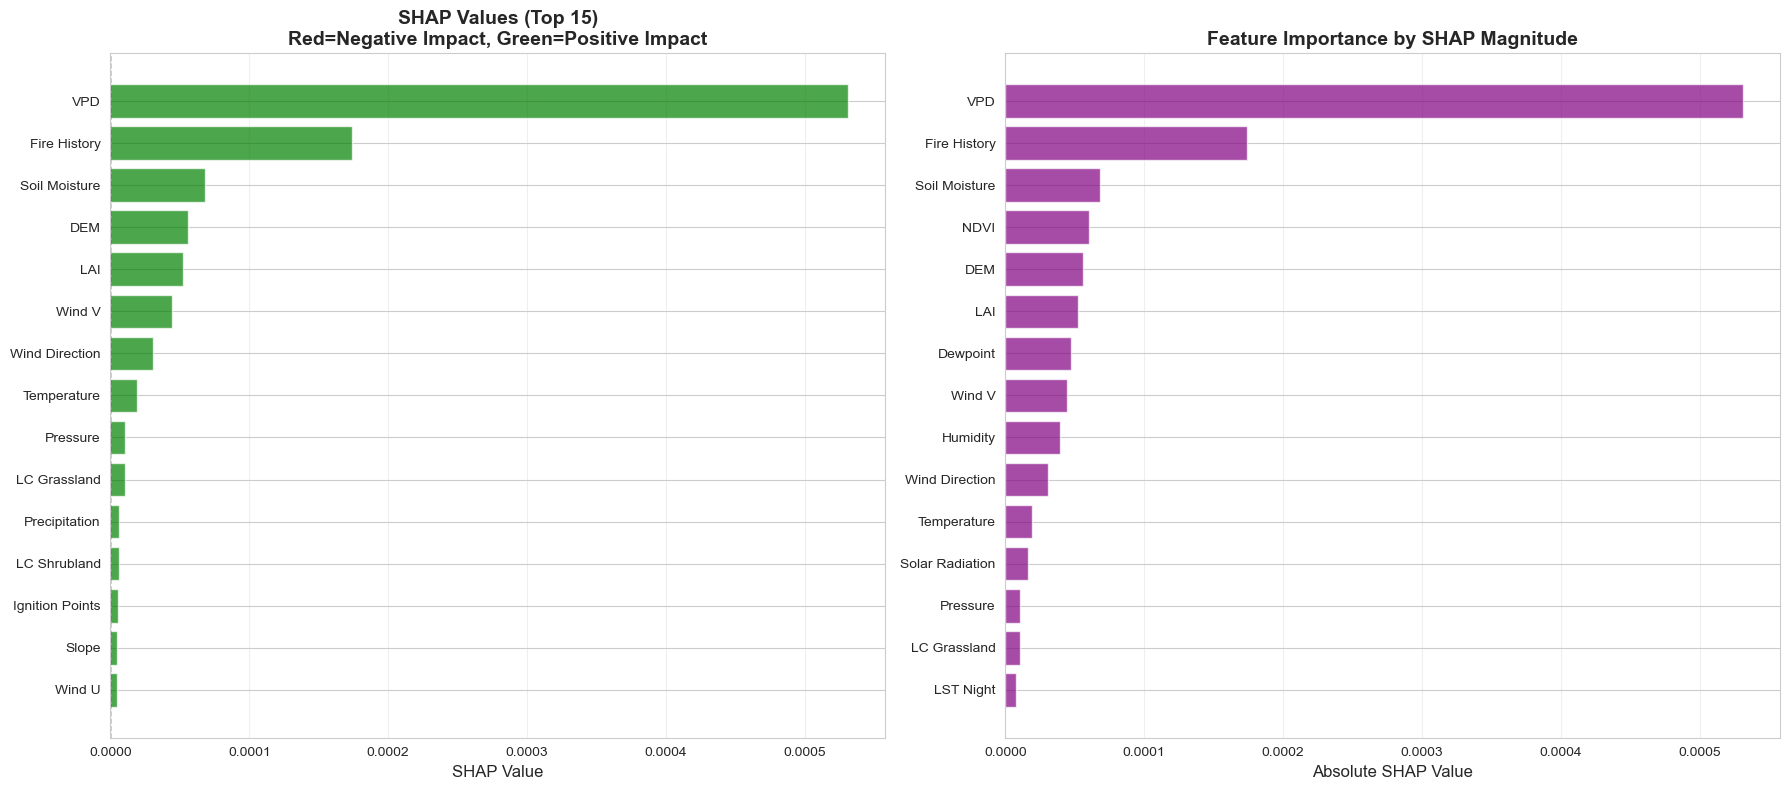

In [25]:
# Display SHAP results
shap_df = pd.DataFrame.from_dict(shap_scores, orient='index', columns=['shap_value'])
shap_df = shap_df.sort_values('shap_value', ascending=False)

print("\n" + "="*80)
print("SHAP ANALYSIS RESULTS")
print("="*80)
print(f"\n{'Feature':<20} {'SHAP Value':<15} {'Abs SHAP':<15}")
print("-"*80)

for feature, row in shap_df.head(15).iterrows():
    print(f"{feature:<20} {row['shap_value']:>14.6f} {abs(row['shap_value']):>14.6f}")

print("="*80)

# Visualize SHAP values
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. SHAP values (with sign)
shap_top = shap_df.head(15).sort_values('shap_value')
colors_shap = ['red' if x < 0 else 'green' for x in shap_top['shap_value']]
axes[0].barh(range(len(shap_top)), shap_top['shap_value'], color=colors_shap, alpha=0.7)
axes[0].set_yticks(range(len(shap_top)))
axes[0].set_yticklabels(shap_top.index, fontsize=10)
axes[0].set_xlabel('SHAP Value', fontsize=12)
axes[0].set_title('SHAP Values (Top 15)\nRed=Negative Impact, Green=Positive Impact', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Absolute SHAP values (magnitude only)
shap_abs = shap_df.copy()
shap_abs['abs_shap'] = shap_abs['shap_value'].abs()
shap_abs = shap_abs.sort_values('abs_shap', ascending=True).tail(15)
axes[1].barh(range(len(shap_abs)), shap_abs['abs_shap'], color='purple', alpha=0.7)
axes[1].set_yticks(range(len(shap_abs)))
axes[1].set_yticklabels(shap_abs.index, fontsize=10)
axes[1].set_xlabel('Absolute SHAP Value', fontsize=12)
axes[1].set_title('Feature Importance by SHAP Magnitude', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('shap_analysis.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved SHAP visualization: shap_analysis.png")
plt.show()


Updating combined analysis with SHAP values...

COMBINED FEATURE IMPORTANCE (Including SHAP)


,Permutation,Gradient,Ablation,SHAP,Average_with_SHAP
VPD,0.8936,1.0000,0.8358,1.0000,0.9323
Fire History,0.1134,0.6393,0.0016,0.3277,0.2705
DEM,-0.0063,0.8285,-0.0041,0.1051,0.2308
Humidity,0.0000,0.5209,0.0013,0.0746,0.1492
Dewpoint,0.0000,0.4988,0.0013,0.0889,0.1472
Curvature,-0.0009,0.5752,0.0013,0.0062,0.1454
NDVI,0.0000,0.4454,0.0013,0.1133,0.1400
Soil Moisture,-0.0035,0.3499,-0.0041,0.1287,0.1177
Wind V,-0.0022,0.3847,-0.0049,0.0842,0.1155
Solar Radiation,0.0071,0.3937,0.0013,0.0307,0.1082



✓ Saved comparison with SHAP: feature_importance_all_methods.png


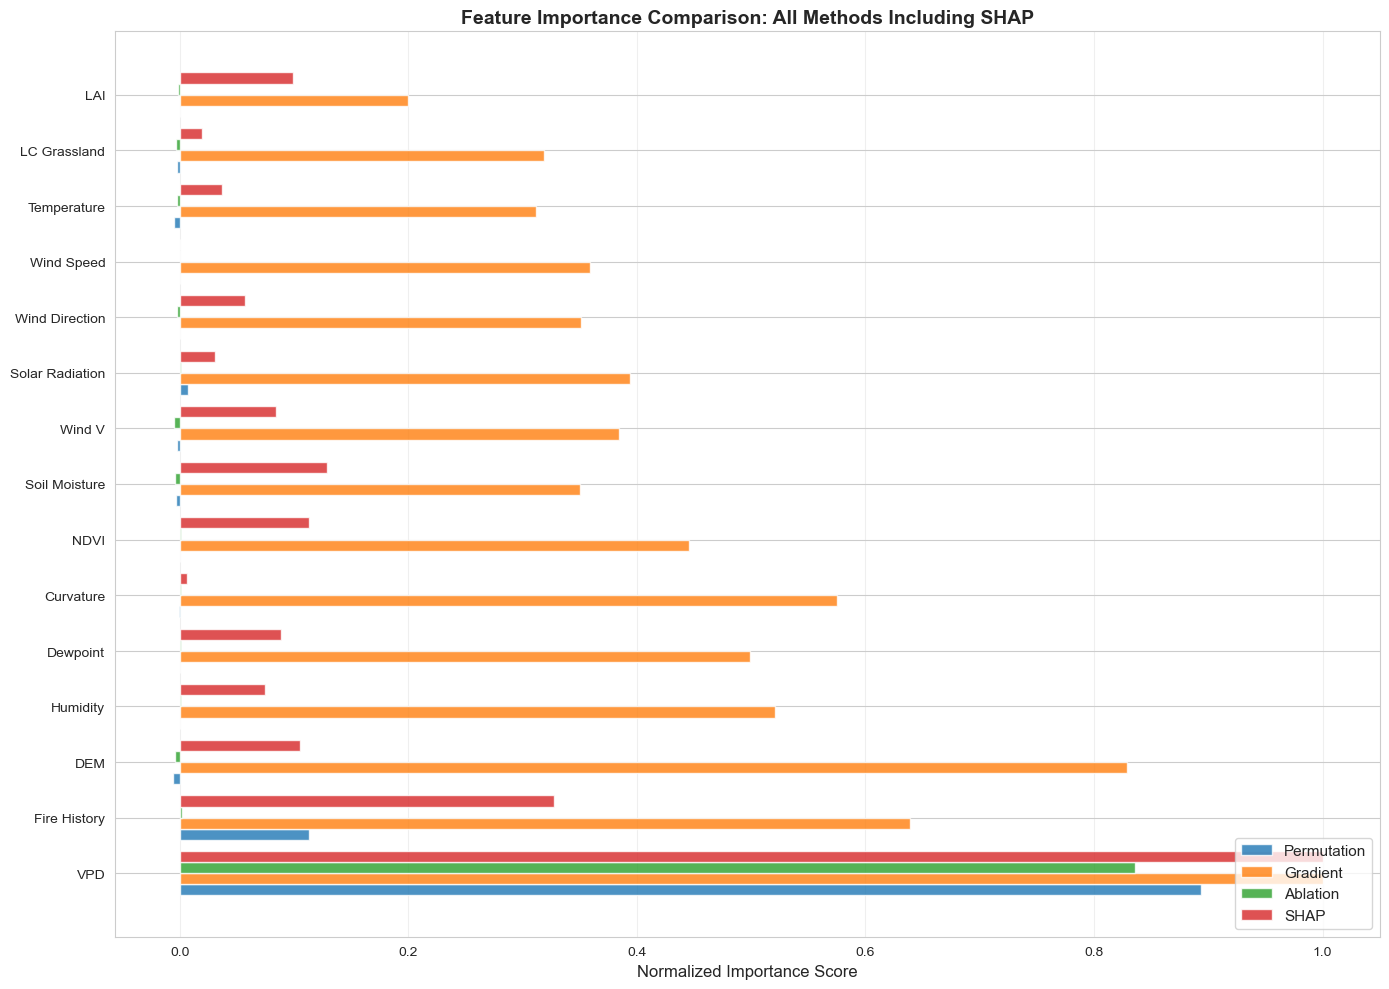

✓ Saved updated results to: /Users/aleemkhan/PycharmProjects/Wildfire-Spread-Simulation/notebooks/feature_importance/feature_importance_with_shap.csv


In [26]:
# Update combined analysis with SHAP
print("\nUpdating combined analysis with SHAP values...")

# Add SHAP to combined dataframe
combined_df_with_shap = combined_df.copy()
combined_df_with_shap['SHAP'] = shap_df['shap_value'].abs()  # Use absolute values for comparison

# Normalize SHAP for fair comparison
combined_df_with_shap['SHAP'] = combined_df_with_shap['SHAP'] / combined_df_with_shap['SHAP'].max()

# Recompute average with SHAP included
combined_df_with_shap['Average_with_SHAP'] = combined_df_with_shap[['Permutation', 'Gradient', 'Ablation', 'SHAP']].mean(axis=1)
combined_df_with_shap = combined_df_with_shap.sort_values('Average_with_SHAP', ascending=False)

print("\n" + "="*80)
print("COMBINED FEATURE IMPORTANCE (Including SHAP)")
print("="*80)
display(combined_df_with_shap[['Permutation', 'Gradient', 'Ablation', 'SHAP', 'Average_with_SHAP']].head(15).round(4))

# Visualize comparison
fig, ax = plt.subplots(figsize=(14, 10))

methods_to_plot = ['Permutation', 'Gradient', 'Ablation', 'SHAP']
top_features = combined_df_with_shap.head(15)

x = np.arange(len(top_features))
width = 0.2

for i, method in enumerate(methods_to_plot):
    offset = (i - 1.5) * width
    ax.barh(x + offset, top_features[method], width, label=method, alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top_features.index, fontsize=10)
ax.set_xlabel('Normalized Importance Score', fontsize=12)
ax.set_title('Feature Importance Comparison: All Methods Including SHAP', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance_all_methods.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved comparison with SHAP: feature_importance_all_methods.png")
plt.show()

# Save updated results
output_file = Path('feature_importance_with_shap.csv')
combined_df_with_shap.to_csv(output_file)
print(f"✓ Saved updated results to: {output_file.absolute()}")